In [13]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
import cv2

# **LOAD ALL THE MODELS**

In [14]:
haar=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
model_svm=pickle.load(open('model_svm.pickle','rb'))
pca_models=pickle.load(open('pca_dict_pickle','rb'))

In [15]:
model_pca=pca_models['pca']
mean_face_arr=pca_models['mean_face']

# **CREATE A PIPELINE**

In [16]:
# read image
#convert image to grayscale
# crop face
#normalisation
# resize images
#flattening
# get eigen image
#visualisation
# pass to svm and predict
# report

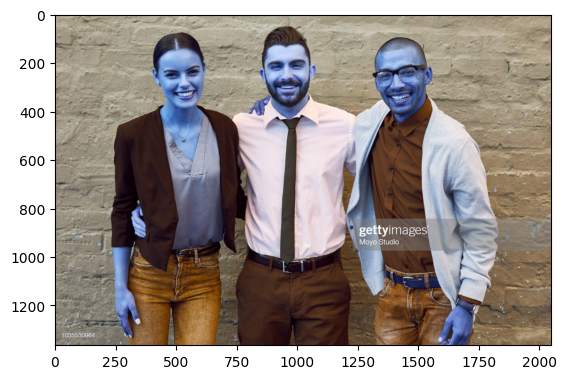

In [17]:
img=cv2.imread('getty_test.jpg') #RGB
plt.imshow(img)
plt.show()

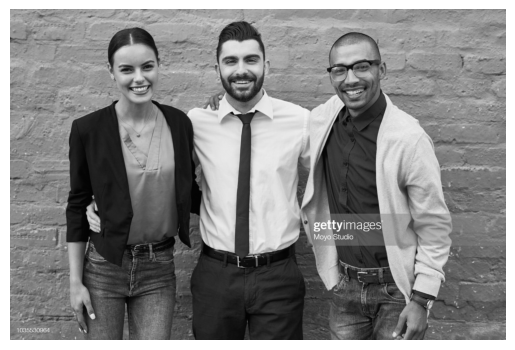

In [18]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')
plt.axis('off')
plt.show()

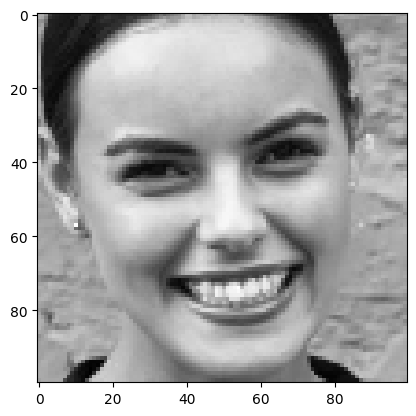

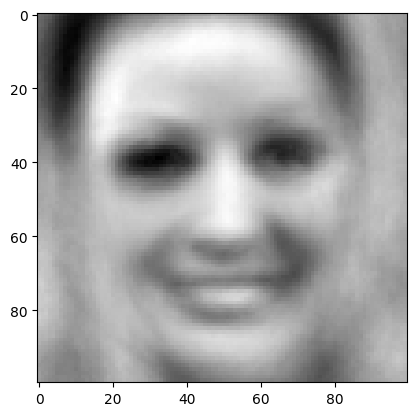

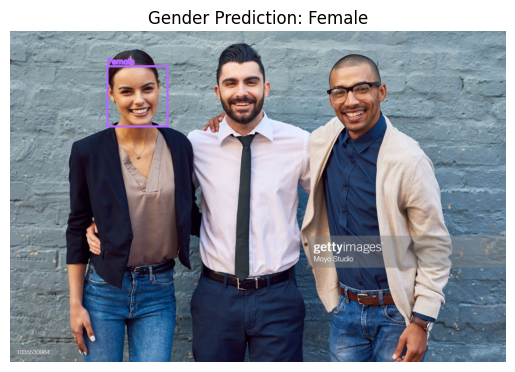

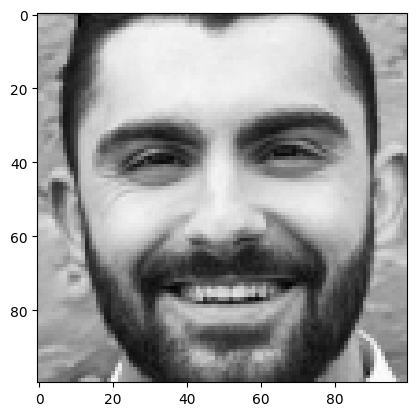

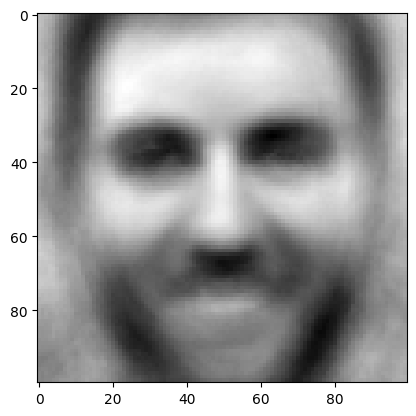

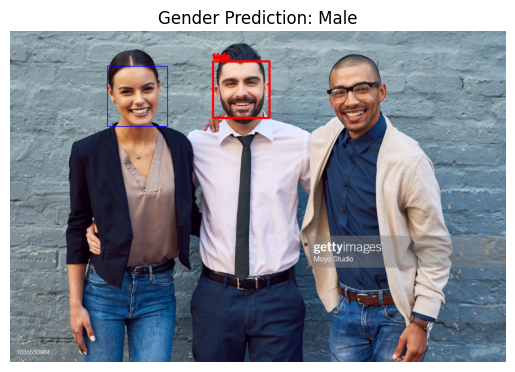

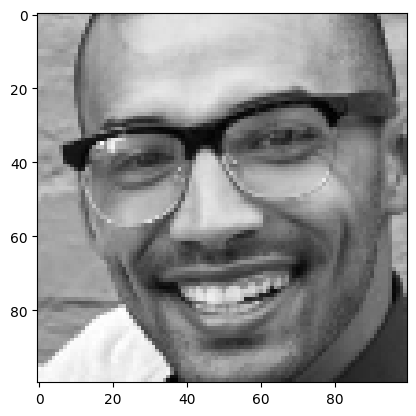

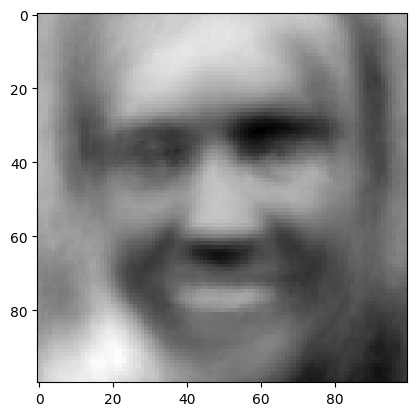

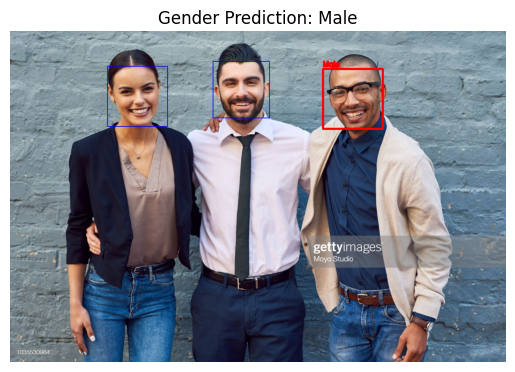

In [19]:
faces=haar.detectMultiScale(gray_img,1.3,5)
predictions=[]
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    crop_img = gray_img[y:y+h,x:x+w]

    # Normalization bringing into 0 to 1 scale
    norm_img = crop_img / 255.0
    # Resize
    resized_img = cv2.resize(norm_img, (100, 100))
    plt.imshow(resized_img, cmap='gray')
    plt.show()

    # Flattening
    flat_img = resized_img.flatten()

    # get eigen image
    eigen_img = model_pca.transform(flat_img.reshape(1,-1))
    inv_img = model_pca.inverse_transform(eigen_img)
    plt.imshow(inv_img.reshape(100,100), cmap='gray')
    plt.show()

    prob_score=model_svm.predict_proba(eigen_img)
    gender = 'female' if prob_score[0][0] > 0.5 else 'male'

    # Define colors for male (blue) and female (pink) in BGR format
    male_color = (0, 0, 255)
    female_color = (255, 105, 180)

    # Determine color and text based on predicted gender
    color = male_color if gender == 'male' else female_color
    text = 'Male' if gender == 'male' else 'Female'

    # Draw the rectangle and text on the image
    # A copy is used to avoid drawing multiple rectangles on the same image in the loop
    img_copy = img.copy()
    cv2.rectangle(img_copy, (x, y), (x+w, y+h), color, 8)
    cv2.putText(img_copy, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 8)

    # Display the final image
    # Convert BGR to RGB for matplotlib display
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Gender Prediction: {text}")
    plt.show()

    # Append a dictionary for each face
    predictions.append({
        'gender': gender,
        'prob_score': prob_score.max(),
        'eigen_img': eigen_img,
        'crop_img': crop_img
    })

In [20]:
print("--- GENDER PREDICTION REPORT ---")
print(f"Predicted Gender: {gender}")
print(f"Confidence Score: {prob_score.max():.2f}")
print("---------------------------------")

--- GENDER PREDICTION REPORT ---
Predicted Gender: male
Confidence Score: 0.79
---------------------------------


In [21]:
#predictions

# **Visualisation**

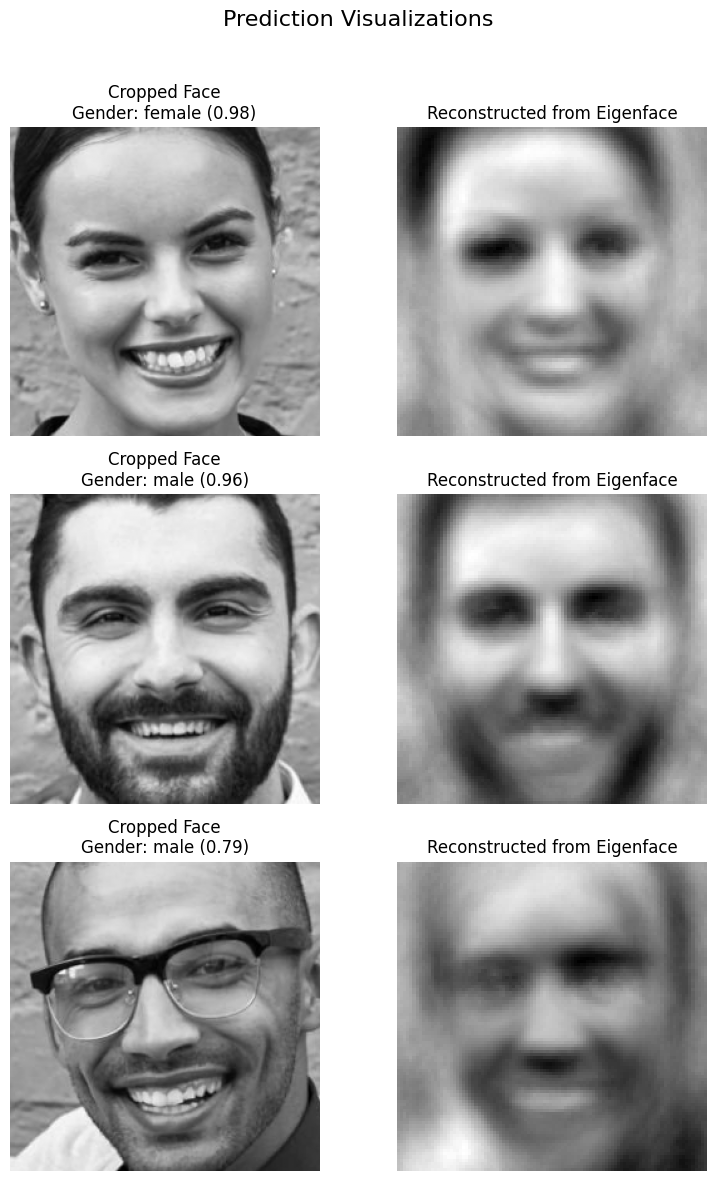

In [22]:
# Set up the plot
num_predictions = len(predictions)
fig, axes = plt.subplots(num_predictions, 2, figsize=(8, 4 * num_predictions))
fig.suptitle('Prediction Visualizations', fontsize=16)

# Handle the case of a single prediction (matplotlib creates a 1D array of axes)
if num_predictions == 1:
    axes = [axes]

for i, prediction in enumerate(predictions):
  # Get data from the prediction dictionary
  obj_img = prediction['crop_img']
  obj_eig_inv = model_pca.inverse_transform(prediction['eigen_img'])
  obj_gender = prediction['gender']
  obj_prob = prediction['prob_score']

  # Display the cropped face
  axes[i][0].imshow(obj_img, cmap='gray')
  axes[i][0].set_title(f'Cropped Face\nGender: {obj_gender} ({obj_prob:.2f})')
  axes[i][0].axis('off')

  # Display the reconstructed (inverse PCA) face
  axes[i][1].imshow(obj_eig_inv.reshape(100, 100), cmap='gray')
  axes[i][1].set_title('Reconstructed from Eigenface')
  axes[i][1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()